# SAM

In [39]:
from huggingface_hub import hf_hub_download

chkpt_path = hf_hub_download("ybelkada/segment-anything", "checkpoints/sam_vit_b_01ec64.pth")

## Data Set-up

In [40]:
import os
import sys
ROOT = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(ROOT, 'src'))
from sen1floods11_dataset import Sen1Floods11Dataset, Sen1Floods11DataModule

In [41]:
DATA_PATH = os.path.join(ROOT, 'sen1floods11', 'hand_labeled.csv')
datamodule = Sen1Floods11DataModule(DATA_PATH, 'HandLabeled', target='Flood', batch_size=8, num_workers=4,
                              debug=True, transforms=[], in_channels=3, expand=1, filter_data=True, normalize=True)
datamodule.setup()

In [42]:
import random
import torch

# Get the train dataloader
train_loader = datamodule.train_dataloader()

# Step 1: Pick a random batch
# Convert the dataloader into an iterator
train_iter = iter(train_loader)

# To get a random batch, you can loop through until a random index
num_batches = len(train_loader)
rand_batch_idx = random.randint(0, num_batches - 1)

for i, batch in enumerate(train_loader):
    if i == rand_batch_idx:
        rand_batch = batch
        break

# Step 2: Pick a random item from that batch
imgs = rand_batch['img']
labels = rand_batch['label']  # adjust key if different
otsu = rand_batch['otsu']

rand_item_idx = torch.randint(0, imgs.shape[0], (1,)).item()
sample_img = imgs[rand_item_idx]
sample_label = labels[rand_item_idx]
sample_otsu = otsu[rand_item_idx]

print(sample_img.shape)
print(sample_label.shape)
print(sample_otsu.shape)


torch.Size([3, 512, 512])
torch.Size([512, 512])
torch.Size([512, 512])


## Using SAM

In [43]:
sample_otsu.min(), sample_otsu.max() 

(tensor(0, dtype=torch.int16), tensor(1, dtype=torch.int16))

In [48]:
mask = sample_otsu.unsqueeze(0)
mask.shape

torch.Size([1, 512, 512])

In [62]:
import torch
import torch.nn.functional as F

# Example mask of size [512, 512]
mask = sample_otsu.unsqueeze(0).unsqueeze(0).float()  # [B, C, H, W] format

# Target size (example: downsample to 256x256)
target_size = (256, 256)

# Interpolate with bilinear or nearest (nearest is better for masks)
prev_mask = F.interpolate(mask, size=target_size,).squeeze(0)

print(prev_mask.shape)  # torch.Size([1, 1, 256, 256])

torch.Size([1, 256, 256])


In [63]:
import torch
from segment_anything import build_sam, sam_model_registry, SamPredictor

# Load SAM model
model = SamPredictor(sam_model_registry["vit_b"](checkpoint=chkpt_path))

# Convert to numpy and move channels last (HWC)
image_np = sample_img.permute(1, 2, 0).cpu().numpy()

# Set image
model.set_image(image_np)

# Predict mask logits for the whole image
# You can pass a point or box prompt; here we use no prompt
masks, scores, logits = model.predict(
    mask_input=prev_mask,
    multimask_output=False  # ensures only one mask
)

# logits has shape (1, 512, 512) — float values
binary_mask = (logits > 0).astype("uint8")  # threshold to get binary mask

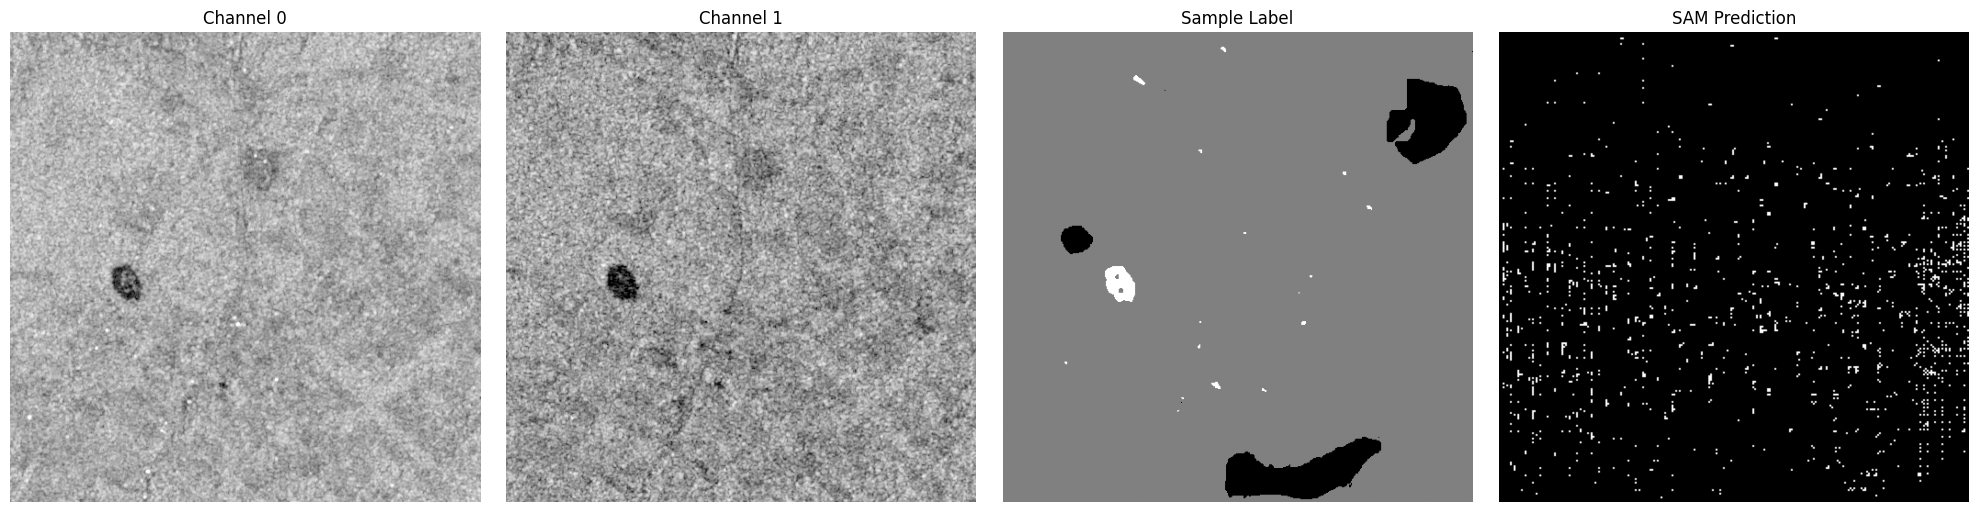

In [ ]:
import matplotlib.pyplot as plt

# sample_img: torch.Size([3, 512, 512])
# sample_label: torch.Size([512, 512])

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

# Channel 0
axs[0].imshow(sample_img[0].cpu(), cmap='gray')
axs[0].set_title("Channel 0")
axs[0].axis("off")

# Channel 1
axs[1].imshow(sample_img[1].cpu(), cmap='gray')
axs[1].set_title("Channel 1")
axs[1].axis("off")

# Label
axs[2].imshow(sample_label.cpu(), cmap='gray')
axs[2].set_title("Sample Label")
axs[2].axis("off")

# Label
axs[3].imshow(sample_otsu.cpu(), cmap='gray')
axs[3].set_title("Sample Otsu")
axs[3].axis("off")

# Preds
axs[4].imshow(binary_mask[0], cmap='gray')
axs[4].set_title("SAM Prediction")
axs[4].axis("off")

plt.tight_layout()
plt.show()